### 作業目的: 實作word2vec Skip-gram模型
在課程中了解如何搭建CBOW模型，這次的作業目的在於透過搭建Skip-gram模型來了解另外一種word2vec的架構。

Hint_1: 學員可以善用課程中以搭建好的function模組
Hint_2: Skip_gram所需的輸入資料與目標跟CBOW有些許不同，Skip_gram是由中間字詞預測上下文

In [3]:
# import modules
import numpy as np
from typing import List
from utils.utility import clip_grads, convert_one_hot, preprocess, Trainer
from utils.layers import Dense, SoftmaxWithCrossEntropy
from utils.optimizer import SGD

In [32]:
# use the same corpus as in the lecture
text = "I am studying Natural Language Processing now."

# define create_contexts_target function
def create_contexts_target(corpus: List, window_size: int=1):

    contexts = []
    targets = []
    for i in range(len(corpus)):
      if i == 0:
        for j in range(1,window_size+1):
          targets.append(corpus[i+j])
      elif i == len(corpus)-1:
        for j in range(1,window_size+1):
          targets.append(corpus[i-j])
      else:
        for j in range(1,window_size+1):
          targets.append(corpus[i+j])
          targets.append(corpus[i-j])
    
    for i in range(len(corpus)):
      if i == 0:
        for j in range(1,window_size+1):
          contexts.append([corpus[i]])
      elif i == len(corpus)-1:
        for j in range(1,window_size+1):
          contexts.append([corpus[i]])
      else:
        for j in range(1,2*window_size+1):
          contexts.append([corpus[i]])

    return np.array(contexts), np.array(targets)

# transform corpus to contexts and targets pair
corpus, word2idx, idx2word = preprocess([text])
contexts, targets= create_contexts_target(corpus[0], window_size=1)
print(corpus[0])
contexts, targets

[0 1 6 2 5 3 7 4]


(array([[0],
        [1],
        [1],
        [6],
        [6],
        [2],
        [2],
        [5],
        [5],
        [3],
        [3],
        [7],
        [7],
        [4]]), array([1, 6, 0, 2, 1, 5, 6, 3, 2, 7, 5, 4, 3, 7]))

In [33]:
# transform contexts and targets to one-hot encoding
contexts = convert_one_hot(contexts, len(word2idx))
targets = convert_one_hot(targets, len(word2idx))
contexts, targets

(array([[[1, 0, 0, 0, 0, 0, 0, 0]],
 
        [[0, 1, 0, 0, 0, 0, 0, 0]],
 
        [[0, 1, 0, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 0, 1, 0]],
 
        [[0, 0, 0, 0, 0, 0, 1, 0]],
 
        [[0, 0, 1, 0, 0, 0, 0, 0]],
 
        [[0, 0, 1, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 1, 0, 0]],
 
        [[0, 0, 0, 0, 0, 1, 0, 0]],
 
        [[0, 0, 0, 1, 0, 0, 0, 0]],
 
        [[0, 0, 0, 1, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 0, 0, 1]],
 
        [[0, 0, 0, 0, 0, 0, 0, 1]],
 
        [[0, 0, 0, 0, 1, 0, 0, 0]]], dtype=int32),
 array([[0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0

In [54]:
print(contexts.shape)
contexts[:,0]

(14, 1, 8)


array([[1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0]], dtype=int32)

In [73]:
# define Skip-gram model
class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size):
        V, H = vocab_size, hidden_size
        self.window_size = window_size

        # initialize weights
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # create layers
        self.in_layer = Dense(W_in)
        self.out_layer = Dense(W_out)
        self.loss_layers = SoftmaxWithCrossEntropy()
        
        layers = [self.in_layer] + [self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # word vector matrix
        self.word_vecs = W_in

    def forward(self, contexts, targets):
        h = self.in_layer.forward(contexts[:, 0])
        s = self.out_layer.forward(h)
        
        loss = self.loss_layers.forward(s, targets)
        return loss

    def backward(self, dout=1):
        
        ds = self.loss_layers.backward(dout)
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        
        return None

In [74]:
# start training

# configurations
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

# define model
skip_gram = SkipGram(vocab_size=len(word2idx), hidden_size=hidden_size, window_size=window_size)
sgd_optimizer = SGD()
trainer = Trainer(skip_gram, sgd_optimizer)

# start training
trainer.fit(contexts, targets, max_epoch, batch_size)

 12%|█▏        | 116/1000 [00:00<00:01, 571.04it/s]

Epoch: 1, Iteration: 1/4, Loss: 2.079507310507989
Epoch: 2, Iteration: 1/4, Loss: 2.079477553483715
Epoch: 3, Iteration: 1/4, Loss: 2.0794906884690496
Epoch: 4, Iteration: 1/4, Loss: 2.0794349130975283
Epoch: 5, Iteration: 1/4, Loss: 2.079355871392582
Epoch: 6, Iteration: 1/4, Loss: 2.07941328837939
Epoch: 7, Iteration: 1/4, Loss: 2.079343664728799
Epoch: 8, Iteration: 1/4, Loss: 2.079320970101064
Epoch: 9, Iteration: 1/4, Loss: 2.0793190698962
Epoch: 10, Iteration: 1/4, Loss: 2.0793383241106964
Epoch: 11, Iteration: 1/4, Loss: 2.079313669905079
Epoch: 12, Iteration: 1/4, Loss: 2.079211300273861
Epoch: 13, Iteration: 1/4, Loss: 2.079259192951284
Epoch: 14, Iteration: 1/4, Loss: 2.0791412616961304
Epoch: 15, Iteration: 1/4, Loss: 2.0790036325292944
Epoch: 16, Iteration: 1/4, Loss: 2.079213677292021
Epoch: 17, Iteration: 1/4, Loss: 2.0790891108147136
Epoch: 18, Iteration: 1/4, Loss: 2.0790686948532495
Epoch: 19, Iteration: 1/4, Loss: 2.0790489115314474
Epoch: 20, Iteration: 1/4, Loss: 2.

 22%|██▏       | 223/1000 [00:00<00:01, 550.85it/s]

Epoch: 118, Iteration: 1/4, Loss: 1.3437983647785976
Epoch: 119, Iteration: 1/4, Loss: 1.386589673004303
Epoch: 120, Iteration: 1/4, Loss: 1.207253842328537
Epoch: 121, Iteration: 1/4, Loss: 1.3661983217764897
Epoch: 122, Iteration: 1/4, Loss: 1.302102580876638
Epoch: 123, Iteration: 1/4, Loss: 1.3549568487272636
Epoch: 124, Iteration: 1/4, Loss: 1.2127742225725338
Epoch: 125, Iteration: 1/4, Loss: 1.1877956284797597
Epoch: 126, Iteration: 1/4, Loss: 1.20467638063491
Epoch: 127, Iteration: 1/4, Loss: 1.2153630112760916
Epoch: 128, Iteration: 1/4, Loss: 1.1977263608577697
Epoch: 129, Iteration: 1/4, Loss: 1.237912869343639
Epoch: 130, Iteration: 1/4, Loss: 1.0932361736792844
Epoch: 131, Iteration: 1/4, Loss: 1.1727662450395244
Epoch: 132, Iteration: 1/4, Loss: 1.1532453177108275
Epoch: 133, Iteration: 1/4, Loss: 1.1434522643954115
Epoch: 134, Iteration: 1/4, Loss: 1.1097457330279659
Epoch: 135, Iteration: 1/4, Loss: 1.0841953847255068
Epoch: 136, Iteration: 1/4, Loss: 1.113993426926975


 34%|███▍      | 341/1000 [00:00<00:01, 567.19it/s]

Epoch: 231, Iteration: 1/4, Loss: 0.6073203290461
Epoch: 232, Iteration: 1/4, Loss: 0.644079583913813
Epoch: 233, Iteration: 1/4, Loss: 0.6258595260981372
Epoch: 234, Iteration: 1/4, Loss: 0.679633930705569
Epoch: 235, Iteration: 1/4, Loss: 0.7812306802536495
Epoch: 236, Iteration: 1/4, Loss: 0.6507409303128187
Epoch: 237, Iteration: 1/4, Loss: 0.6599591603343218
Epoch: 238, Iteration: 1/4, Loss: 0.6808592994228391
Epoch: 239, Iteration: 1/4, Loss: 0.7184570339964135
Epoch: 240, Iteration: 1/4, Loss: 0.6265945443762297
Epoch: 241, Iteration: 1/4, Loss: 0.725421364024829
Epoch: 242, Iteration: 1/4, Loss: 0.6302332695851884
Epoch: 243, Iteration: 1/4, Loss: 0.7175735649131811
Epoch: 244, Iteration: 1/4, Loss: 0.6599697413666019
Epoch: 245, Iteration: 1/4, Loss: 0.6747802503041642
Epoch: 246, Iteration: 1/4, Loss: 0.7294275438307998
Epoch: 247, Iteration: 1/4, Loss: 0.6998916200335504
Epoch: 248, Iteration: 1/4, Loss: 0.6877902041414599
Epoch: 249, Iteration: 1/4, Loss: 0.5259613805335904

 46%|████▌     | 459/1000 [00:00<00:00, 576.91it/s]

Epoch: 354, Iteration: 1/4, Loss: 0.6251778140412114
Epoch: 355, Iteration: 1/4, Loss: 0.7394463474504573
Epoch: 356, Iteration: 1/4, Loss: 0.6176272948544022
Epoch: 357, Iteration: 1/4, Loss: 0.6370048735056488
Epoch: 358, Iteration: 1/4, Loss: 0.6102910414063302
Epoch: 359, Iteration: 1/4, Loss: 0.6934767815815195
Epoch: 360, Iteration: 1/4, Loss: 0.6412202333880903
Epoch: 361, Iteration: 1/4, Loss: 0.6479299390608365
Epoch: 362, Iteration: 1/4, Loss: 0.7768538860452189
Epoch: 363, Iteration: 1/4, Loss: 0.6093824099182856
Epoch: 364, Iteration: 1/4, Loss: 0.5570266708876822
Epoch: 365, Iteration: 1/4, Loss: 0.6311023314753815
Epoch: 366, Iteration: 1/4, Loss: 0.739271938608185
Epoch: 367, Iteration: 1/4, Loss: 0.6584983547778137
Epoch: 368, Iteration: 1/4, Loss: 0.6233070141418644
Epoch: 369, Iteration: 1/4, Loss: 0.643093773509744
Epoch: 370, Iteration: 1/4, Loss: 0.7132605578458435
Epoch: 371, Iteration: 1/4, Loss: 0.5671083534808331
Epoch: 372, Iteration: 1/4, Loss: 0.727838609081

 58%|█████▊    | 579/1000 [00:01<00:00, 587.75it/s]

Epoch: 476, Iteration: 1/4, Loss: 0.6476366273413365
Epoch: 477, Iteration: 1/4, Loss: 0.6267595612880855
Epoch: 478, Iteration: 1/4, Loss: 0.6438240658247711
Epoch: 479, Iteration: 1/4, Loss: 0.5952147258589218
Epoch: 480, Iteration: 1/4, Loss: 0.6902365805024363
Epoch: 481, Iteration: 1/4, Loss: 0.6399406127330034
Epoch: 482, Iteration: 1/4, Loss: 0.6515381752078713
Epoch: 483, Iteration: 1/4, Loss: 0.6573172616904509
Epoch: 484, Iteration: 1/4, Loss: 0.69199290089752
Epoch: 485, Iteration: 1/4, Loss: 0.553623373677138
Epoch: 486, Iteration: 1/4, Loss: 0.7451945882558648
Epoch: 487, Iteration: 1/4, Loss: 0.6880077940538525
Epoch: 488, Iteration: 1/4, Loss: 0.5599531194984394
Epoch: 489, Iteration: 1/4, Loss: 0.6616652703559258
Epoch: 490, Iteration: 1/4, Loss: 0.7564779537513064
Epoch: 491, Iteration: 1/4, Loss: 0.6302998050234107
Epoch: 492, Iteration: 1/4, Loss: 0.7116412640234692
Epoch: 493, Iteration: 1/4, Loss: 0.6233960404750829
Epoch: 494, Iteration: 1/4, Loss: 0.5611055040976

 70%|██████▉   | 695/1000 [00:01<00:00, 576.62it/s]

Epoch: 600, Iteration: 1/4, Loss: 0.6424013844785832
Epoch: 601, Iteration: 1/4, Loss: 0.6682122831321187
Epoch: 602, Iteration: 1/4, Loss: 0.678308691566782
Epoch: 603, Iteration: 1/4, Loss: 0.5566615167495302
Epoch: 604, Iteration: 1/4, Loss: 0.6284005355603773
Epoch: 605, Iteration: 1/4, Loss: 0.6934985951856039
Epoch: 606, Iteration: 1/4, Loss: 0.6775620260220017
Epoch: 607, Iteration: 1/4, Loss: 0.5952924471308234
Epoch: 608, Iteration: 1/4, Loss: 0.7111820908987899
Epoch: 609, Iteration: 1/4, Loss: 0.7605727484639763
Epoch: 610, Iteration: 1/4, Loss: 0.6629833234854521
Epoch: 611, Iteration: 1/4, Loss: 0.6531004064206481
Epoch: 612, Iteration: 1/4, Loss: 0.6507915920223837
Epoch: 613, Iteration: 1/4, Loss: 0.6203167662788848
Epoch: 614, Iteration: 1/4, Loss: 0.6665784663740855
Epoch: 615, Iteration: 1/4, Loss: 0.5830318729740556
Epoch: 616, Iteration: 1/4, Loss: 0.6960818745388079
Epoch: 617, Iteration: 1/4, Loss: 0.7712346886533703
Epoch: 618, Iteration: 1/4, Loss: 0.63955553010

 82%|████████▏ | 816/1000 [00:01<00:00, 589.43it/s]

Epoch: 720, Iteration: 1/4, Loss: 0.71955582016065
Epoch: 721, Iteration: 1/4, Loss: 0.6414639328857948
Epoch: 722, Iteration: 1/4, Loss: 0.672923889637334
Epoch: 723, Iteration: 1/4, Loss: 0.5125037443245701
Epoch: 724, Iteration: 1/4, Loss: 0.6835430034833196
Epoch: 725, Iteration: 1/4, Loss: 0.736560946215383
Epoch: 726, Iteration: 1/4, Loss: 0.5583035083884266
Epoch: 727, Iteration: 1/4, Loss: 0.6284544404306436
Epoch: 728, Iteration: 1/4, Loss: 0.7126947944248185
Epoch: 729, Iteration: 1/4, Loss: 0.5695759321408795
Epoch: 730, Iteration: 1/4, Loss: 0.6941748473913375
Epoch: 731, Iteration: 1/4, Loss: 0.6497098490605573
Epoch: 732, Iteration: 1/4, Loss: 0.6540374443062325
Epoch: 733, Iteration: 1/4, Loss: 0.5475994734703249
Epoch: 734, Iteration: 1/4, Loss: 0.7212949099838242
Epoch: 735, Iteration: 1/4, Loss: 0.5236066726096184
Epoch: 736, Iteration: 1/4, Loss: 0.7516636197973439
Epoch: 737, Iteration: 1/4, Loss: 0.5683919900617765
Epoch: 738, Iteration: 1/4, Loss: 0.68227493782715

 93%|█████████▎| 933/1000 [00:01<00:00, 572.01it/s]

Epoch: 847, Iteration: 1/4, Loss: 0.5689267000252736
Epoch: 848, Iteration: 1/4, Loss: 0.6728793222617476
Epoch: 849, Iteration: 1/4, Loss: 0.6230623964213629
Epoch: 850, Iteration: 1/4, Loss: 0.7705661407808191
Epoch: 851, Iteration: 1/4, Loss: 0.5930449020288319
Epoch: 852, Iteration: 1/4, Loss: 0.5989764252407774
Epoch: 853, Iteration: 1/4, Loss: 0.6283221400901596
Epoch: 854, Iteration: 1/4, Loss: 0.6783817401961917
Epoch: 855, Iteration: 1/4, Loss: 0.7422393655408945
Epoch: 856, Iteration: 1/4, Loss: 0.6234900618725187
Epoch: 857, Iteration: 1/4, Loss: 0.6904191516354876
Epoch: 858, Iteration: 1/4, Loss: 0.6749945956986563
Epoch: 859, Iteration: 1/4, Loss: 0.6779876877787433
Epoch: 860, Iteration: 1/4, Loss: 0.5306717794881167
Epoch: 861, Iteration: 1/4, Loss: 0.69178980464114
Epoch: 862, Iteration: 1/4, Loss: 0.5844814422511418
Epoch: 863, Iteration: 1/4, Loss: 0.6658843310695508
Epoch: 864, Iteration: 1/4, Loss: 0.6575871859191347
Epoch: 865, Iteration: 1/4, Loss: 0.811500431509

100%|██████████| 1000/1000 [00:01<00:00, 567.67it/s]

Epoch: 963, Iteration: 1/4, Loss: 0.5418295923543079
Epoch: 964, Iteration: 1/4, Loss: 0.6121596206601774
Epoch: 965, Iteration: 1/4, Loss: 0.6533260372437443
Epoch: 966, Iteration: 1/4, Loss: 0.6596933321456363
Epoch: 967, Iteration: 1/4, Loss: 0.5558708302545848
Epoch: 968, Iteration: 1/4, Loss: 0.7249802971508701
Epoch: 969, Iteration: 1/4, Loss: 0.6635403986994858
Epoch: 970, Iteration: 1/4, Loss: 0.6458514818570841
Epoch: 971, Iteration: 1/4, Loss: 0.7375146348791773
Epoch: 972, Iteration: 1/4, Loss: 0.6953568104408888
Epoch: 973, Iteration: 1/4, Loss: 0.7097468983932309
Epoch: 974, Iteration: 1/4, Loss: 0.6199581925068987
Epoch: 975, Iteration: 1/4, Loss: 0.5640679266869215
Epoch: 976, Iteration: 1/4, Loss: 0.7213517478213979
Epoch: 977, Iteration: 1/4, Loss: 0.7583515577433328
Epoch: 978, Iteration: 1/4, Loss: 0.5724387854648552
Epoch: 979, Iteration: 1/4, Loss: 0.7036533592259012
Epoch: 980, Iteration: 1/4, Loss: 0.5901255635913574
Epoch: 981, Iteration: 1/4, Loss: 0.6450580717

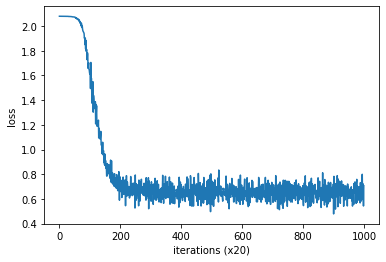

In [75]:
trainer.plot()

In [76]:
# check skip-gram results
word_vecs = skip_gram.word_vecs
for word_id, word in idx2word.items():
    print(word, word_vecs[word_id])

i [-0.53809035 -0.4467873  -2.6722562   0.42021564  0.14867474]
am [-1.4951354  0.9941296  0.0278322  1.4848105  0.4127766]
natural [-0.9229579   0.85019934  1.6514637  -0.32681158  1.2177386 ]
processing [ 1.2643836   1.0585014   1.4706359  -0.3881488   0.23361292]
. [ 2.0295157   1.5786875   0.174785    0.86859226 -0.55022347]
language [-0.18980174 -1.8663727   0.5724018  -1.4319438  -0.04213441]
studying [-0.95576495 -1.131743   -1.2904958  -0.676522    0.8420146 ]
now [ 0.7434502  -1.1151798   0.15626171 -0.20798522 -1.9552597 ]
